
# Спам‑фильтр на UCI Spambase  
Анализ данных → препроцессинг → эксперименты с **Перцептроном** и **Логистической регрессией** → подбор гиперпараметров и регуляризации → итоговое сравнение и интерпретация.

**Состав ноутбука**
1. Загрузка и первичный анализ
2. Визуализация
3. Препроцессинг (скалирование/one‑hot)
4. Бейзлайны
5. Подбор гиперпараметров (GridSearchCV)
6. Итоговая оценка на тесте, ROC/PR, матрицы ошибок
7. Валидационные и обучающие кривые
8. Интерпретируемость (коэффициенты логрега)
9. Доп. эксперименты с регуляризаторами
10. Сохранение лучших моделей


In [1]:

# Библиотеки и настройки
import os, io, zipfile, warnings, itertools, pathlib, joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import (
    train_test_split, StratifiedKFold, RepeatedStratifiedKFold,
    cross_validate, GridSearchCV, validation_curve, learning_curve
)
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    roc_auc_score, roc_curve, auc, precision_recall_curve, average_precision_score
)
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.decomposition import PCA

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", 200)
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
sns.set_theme(context="notebook", style="whitegrid")



## 1. Загрузка датасета

* Если рядом лежат `spambase.data`/`spambase.zip` — читаем их.  
* Иначе — пытаемся скачать с UCI (при отсутствии интернета загрузка не выполнится, положите файл локально).


In [2]:

# Имена признаков из документации UCI (57 признаков + целевая 'spam')
word_freq = [
    "make","address","all","3d","our","over","remove","internet","order","mail","receive",
    "will","people","report","addresses","free","business","email","you","credit","your",
    "font","000","money","hp","hpl","george","650","lab","labs","telnet","857","data","415",
    "85","technology","1999","parts","pm","direct","cs","meeting","original","project","re",
    "edu","table","conference"
]
char_freq = [f"char_freq_{c}" for c in ["semicolon","lbracket","lparen","exclam","dollar","hash"]]
capital_feats = ["capital_run_length_average","capital_run_length_longest","capital_run_length_total"]
SPAMBASE_COLUMNS = [f"word_freq_{w}" for w in word_freq] + char_freq + capital_feats + ["spam"]

def load_spambase(path: str = ".") -> pd.DataFrame:
    for fname in ["spambase.data", "spambase.csv"]:
        f = os.path.join(path, fname)
        if os.path.exists(f):
            return pd.read_csv(f, header=None, names=SPAMBASE_COLUMNS)
    zf = os.path.join(path, "spambase.zip")
    if os.path.exists(zf):
        with zipfile.ZipFile(zf, "r") as z:
            inner = [n for n in z.namelist() if n.endswith("spambase.data")]
            if inner:
                with z.open(inner[0]) as f:
                    return pd.read_csv(f, header=None, names=SPAMBASE_COLUMNS)
    # Fallback: UCI
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/spambase/spambase.data"
    try:
        return pd.read_csv(url, header=None, names=SPAMBASE_COLUMNS)
    except Exception as e:
        raise RuntimeError("Не найден локальный файл и нет доступа к UCI. Положите spambase.data рядом с ноутбуком.") from e

df = load_spambase()
df.head()


,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,word_freq_receive,word_freq_will,word_freq_people,word_freq_report,word_freq_addresses,word_freq_free,word_freq_business,word_freq_email,word_freq_you,word_freq_credit,word_freq_your,word_freq_font,word_freq_000,word_freq_money,word_freq_hp,word_freq_hpl,word_freq_george,word_freq_650,word_freq_lab,word_freq_labs,word_freq_telnet,word_freq_857,word_freq_data,word_freq_415,word_freq_85,word_freq_technology,word_freq_1999,word_freq_parts,word_freq_pm,word_freq_direct,word_freq_cs,word_freq_meeting,word_freq_original,word_freq_project,word_freq_re,word_freq_edu,word_freq_table,word_freq_conference,char_freq_semicolon,char_freq_lbracket,char_freq_lparen,char_freq_exclam,char_freq_dollar,char_freq_hash,capital_run_length_average,capital_run_length_longest,capital_run_length_total,spam
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,0.00,0.64,0.00,0.00,0.00,0.32,0.00,1.29,1.93,0.00,0.96,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,0.21,0.79,0.65,0.21,0.14,0.14,0.07,0.28,3.47,0.00,1.59,0.0,0.43,0.43,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.07,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,0.38,0.45,0.12,0.00,1.75,0.06,0.06,1.03,1.36,0.32,0.51,0.0,1.16,0.06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.06,0.0,0.0,0.12,0.0,0.06,0.06,0.0,0.0,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,0.31,0.31,0.31,0.00,0.00,0.31,0.00,0.00,3.18,0.00,0.31,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,0.31,0.31,0.31,0.00,0.00,0.31,0.00,0.00,3.18,0.00,0.31,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1



## 2. Базовый анализ
Размер, типы, пропуски, баланс классов, описательная статистика.


In [3]:

print("Размер:", df.shape)
print("\nТипы признаков:\n", df.dtypes.value_counts())
print("\nЧисло пропусков всего:", int(df.isna().sum().sum()))

print("\nБаланс классов (0=ham, 1=spam):")
balance = df["spam"].value_counts().rename("count").to_frame().assign(frac=lambda s: s["count"]/len(df))
balance


Размер: (4601, 58)

Типы признаков:
 float64    55
int64       3
Name: count, dtype: int64

Число пропусков всего: 0

Баланс классов (0=ham, 1=spam):


,count,frac
spam,,
0,2788,0.605955
1,1813,0.394045


In [4]:

# Описательная статистика (первые 10 признаков для компактности)
df.describe().T.round(3).iloc[:10]


,count,mean,std,min,25%,50%,75%,max
word_freq_make,4601.0,0.105,0.305,0.0,0.0,0.0,0.00,4.54
word_freq_address,4601.0,0.213,1.291,0.0,0.0,0.0,0.00,14.28
word_freq_all,4601.0,0.281,0.504,0.0,0.0,0.0,0.42,5.10
word_freq_3d,4601.0,0.065,1.395,0.0,0.0,0.0,0.00,42.81
word_freq_our,4601.0,0.312,0.673,0.0,0.0,0.0,0.38,10.00
word_freq_over,4601.0,0.096,0.274,0.0,0.0,0.0,0.00,5.88
word_freq_remove,4601.0,0.114,0.391,0.0,0.0,0.0,0.00,7.27
word_freq_internet,4601.0,0.105,0.401,0.0,0.0,0.0,0.00,11.11
word_freq_order,4601.0,0.090,0.279,0.0,0.0,0.0,0.00,5.26
word_freq_mail,4601.0,0.239,0.645,0.0,0.0,0.0,0.16,18.18


In [5]:

# Корреляции с целевой
corr = df.corr(numeric_only=True)
top_to_spam = corr["spam"].sort_values(key=np.abs, ascending=False).head(15)
top_to_spam.to_frame("corr_with_spam").round(3)


,corr_with_spam
spam,1.000
word_freq_your,0.383
word_freq_000,0.335
word_freq_remove,0.332
char_freq_dollar,0.324
word_freq_you,0.274
word_freq_free,0.263
word_freq_business,0.263
word_freq_hp,-0.257
capital_run_length_total,0.249


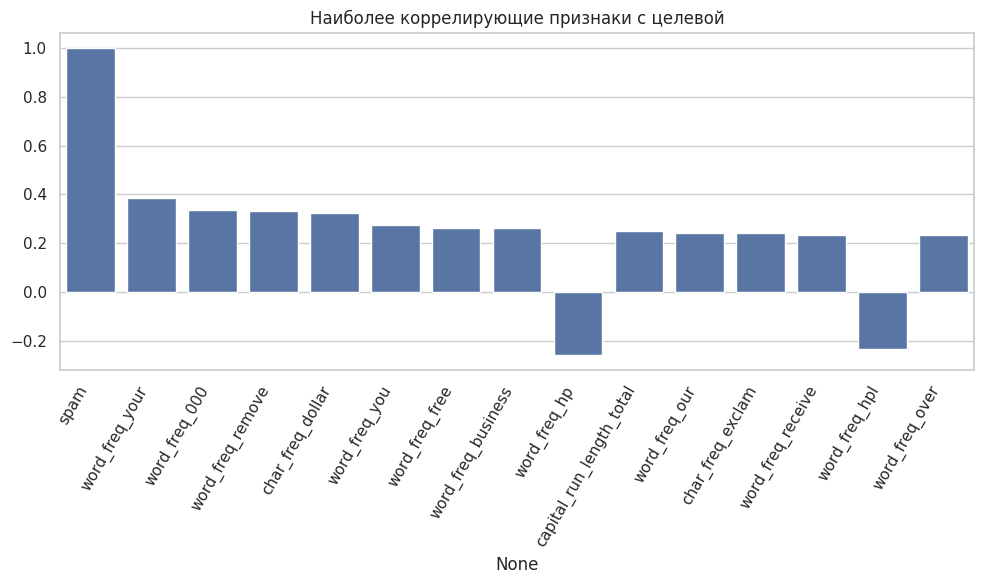

In [6]:

plt.figure(figsize=(10,6))
sns.barplot(x=top_to_spam.index, y=top_to_spam.values)
plt.xticks(rotation=60, ha="right"); plt.title("Наиболее коррелирующие признаки с целевой")
plt.tight_layout(); plt.show()



## 3. Визуализация распределений


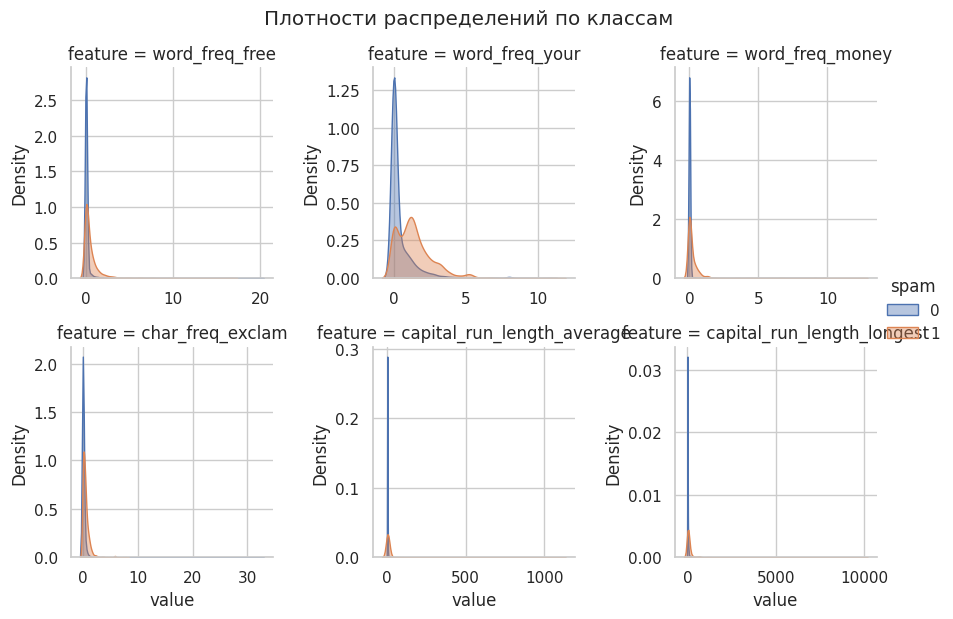

In [7]:

cols_demo = ["word_freq_free","word_freq_your","word_freq_money","char_freq_exclam",
             "capital_run_length_average","capital_run_length_longest"]
melted = df[cols_demo+["spam"]].melt("spam", var_name="feature", value_name="value")
g = sns.FacetGrid(melted, col="feature", col_wrap=3, height=3, sharex=False, sharey=False, hue="spam")
g.map(sns.kdeplot, "value", common_norm=False, fill=True, alpha=0.4)
g.add_legend(title="spam"); plt.suptitle("Плотности распределений по классам", y=1.03); plt.show()


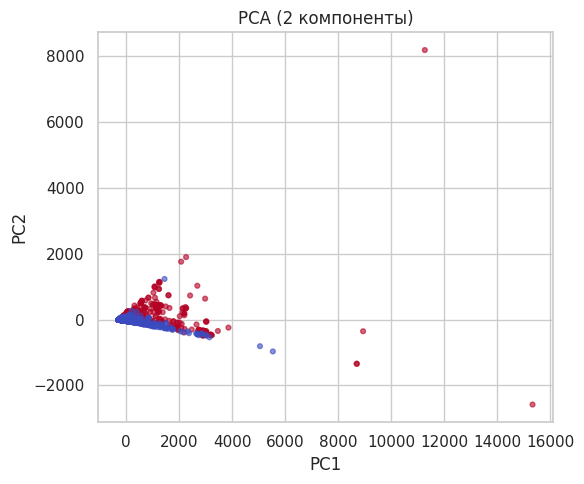

In [8]:

# Быстрый 2D‑обзор через PCA
X_num = df.drop(columns=["spam"]).values
y = df["spam"].values
X_pca = PCA(n_components=2, random_state=RANDOM_STATE).fit_transform(X_num)

plt.figure(figsize=(6,5))
plt.scatter(X_pca[:,0], X_pca[:,1], c=y, s=12, alpha=0.6, cmap="coolwarm")
plt.title("PCA (2 компоненты)"); plt.xlabel("PC1"); plt.ylabel("PC2"); plt.tight_layout(); plt.show()



## 4. Препроцессинг
* Числовые → `StandardScaler`  
* Категориальные (их нет, но поддержка на случай расширений) → `OneHotEncoder`


In [9]:

feature_cols = [c for c in df.columns if c!="spam"]
cat_cols = [c for c in feature_cols if df[c].dtype=="object"]
num_cols = [c for c in feature_cols if c not in cat_cols]

preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols),
    ],
    remainder="drop",
    verbose_feature_names_out=False
)

X = df[feature_cols]
y = df["spam"].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

print(f"Train: {X_train.shape}, Test: {X_test.shape}, Spam rate train: {y_train.mean():.3f}")


Train: (3680, 57), Test: (921, 57), Spam rate train: 0.394



## 5. Бейзлайны (без подбора)
Кросс‑валидация (StratifiedKFold, 5 фолдов).


In [10]:

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
scoring = {"roc_auc":"roc_auc", "f1":"f1", "bal_acc":"balanced_accuracy", "ap":"average_precision"}

def evaluate_cv(pipe, X, y, name):
    res = cross_validate(pipe, X, y, cv=cv, scoring=scoring, n_jobs=-1, return_train_score=False)
    row = {f"cv_{k}":res[f"test_{k}"].mean() for k in scoring}
    row.update({f"std_{k}":res[f"test_{k}"].std() for k in scoring})
    row["model"] = name
    return row

pipe_lr_base = Pipeline([("prep", preprocess),
                         ("clf", LogisticRegression(max_iter=500, solver="saga", random_state=RANDOM_STATE))])

pipe_pc_base = Pipeline([("prep", preprocess),
                         ("clf", Perceptron(random_state=RANDOM_STATE))])

rows = []
rows.append(evaluate_cv(pipe_lr_base, X, y, "LogReg base"))
rows.append(evaluate_cv(pipe_pc_base, X, y, "Perceptron base"))
cv_table = pd.DataFrame(rows).set_index("model").sort_values("cv_roc_auc", ascending=False)
cv_table.round(4)


,cv_roc_auc,cv_f1,cv_bal_acc,cv_ap,std_roc_auc,std_f1,std_bal_acc,std_ap
model,,,,,,,,
LogReg base,0.9705,0.9001,0.9157,0.9452,0.0023,0.0119,0.0104,0.0058
Perceptron base,0.9554,0.8774,0.9003,0.9197,0.0113,0.0154,0.0127,0.0211



## 6. Подбор гиперпараметров
### Логистическая регрессия


In [11]:

pipe_lr = Pipeline([
    ("prep", preprocess),
    ("clf", LogisticRegression(solver="saga", max_iter=5000, random_state=RANDOM_STATE))
])

grid_lr = [
    {"clf__penalty": ["l2"],
     "clf__C": np.logspace(-3, 3, 13),
     "clf__class_weight": [None, "balanced"]},
    {"clf__penalty": ["l1"],
     "clf__C": np.logspace(-3, 3, 13),
     "clf__class_weight": [None, "balanced"]},
    {"clf__penalty": ["elasticnet"],
     "clf__l1_ratio": [0.1, 0.3, 0.5, 0.7, 0.9],
     "clf__C": np.logspace(-3, 3, 13),
     "clf__class_weight": [None, "balanced"]},
]

gs_lr = GridSearchCV(pipe_lr, grid_lr, cv=cv, scoring="roc_auc", n_jobs=-1, refit=True, verbose=0)
gs_lr.fit(X_train, y_train)

print("Best LR params:", gs_lr.best_params_)
print("Best CV ROC-AUC:", round(gs_lr.best_score_, 5))


Best LR params: {'clf__C': np.float64(3.1622776601683795), 'clf__class_weight': 'balanced', 'clf__penalty': 'l1'}
Best CV ROC-AUC: 0.97124



### Перцептрон


In [12]:

pipe_pc = Pipeline([("prep", preprocess), ("clf", Perceptron(random_state=RANDOM_STATE))])

grid_pc = {
    "clf__penalty": [None, "l2", "l1", "elasticnet"],
    "clf__alpha": np.logspace(-6, -1, 6),
    "clf__l1_ratio": [0.0, 0.15, 0.5, 0.85],
    "clf__class_weight": [None, "balanced"],
    "clf__early_stopping": [True],
    "clf__validation_fraction": [0.1, 0.2],
    "clf__max_iter": [2000, 4000],
    "clf__eta0": [0.1, 1.0],
    "clf__shuffle": [True]
}

gs_pc = GridSearchCV(pipe_pc, grid_pc, cv=cv, scoring="roc_auc", n_jobs=-1, refit=True, verbose=0)
gs_pc.fit(X_train, y_train)

print("Best Perceptron params:", gs_pc.best_params_)
print("Best CV ROC-AUC:", round(gs_pc.best_score_, 5))


Best Perceptron params: {'clf__alpha': np.float64(0.0001), 'clf__class_weight': None, 'clf__early_stopping': True, 'clf__eta0': 0.1, 'clf__l1_ratio': 0.15, 'clf__max_iter': 2000, 'clf__penalty': 'elasticnet', 'clf__shuffle': True, 'clf__validation_fraction': 0.2}
Best CV ROC-AUC: 0.95886



## 7. Итоговая оценка на тесте
Матрица ошибок, ROC и PR‑кривые.


=== LogisticRegression (best) ===
              precision    recall  f1-score   support

           0     0.9452    0.9265    0.9357       558
           1     0.8904    0.9174    0.9037       363

    accuracy                         0.9229       921
   macro avg     0.9178    0.9219    0.9197       921
weighted avg     0.9236    0.9229    0.9231       921



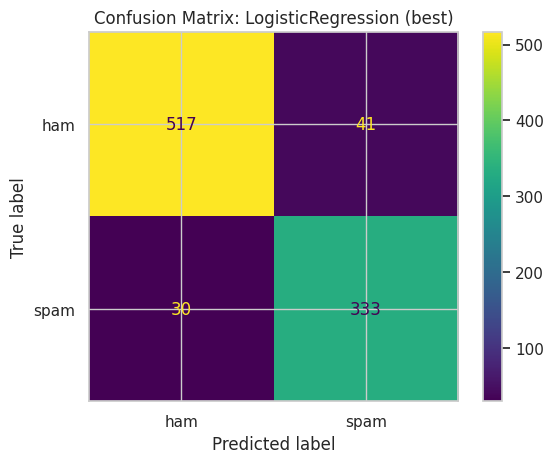

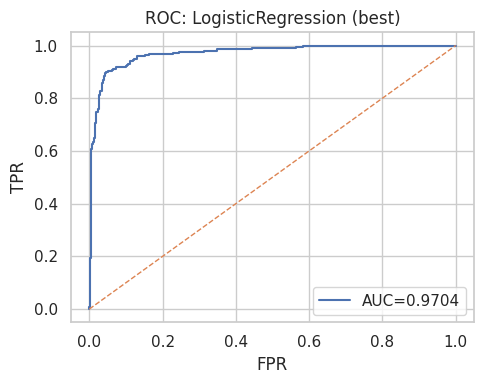

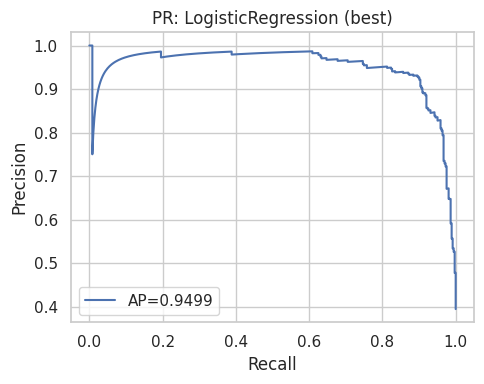

=== Perceptron (best) ===
              precision    recall  f1-score   support

           0     0.8436    0.8118    0.8274       558
           1     0.7266    0.7686    0.7470       363

    accuracy                         0.7948       921
   macro avg     0.7851    0.7902    0.7872       921
weighted avg     0.7975    0.7948    0.7957       921



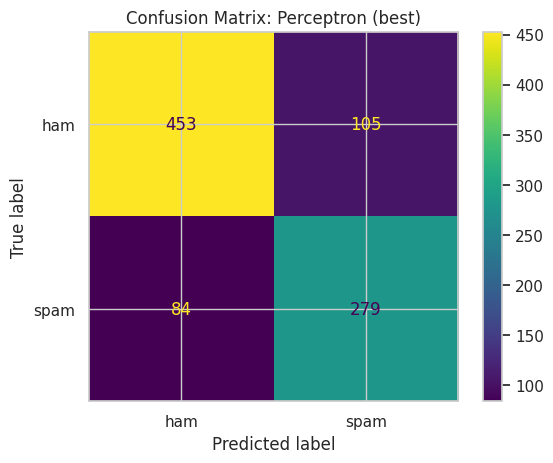

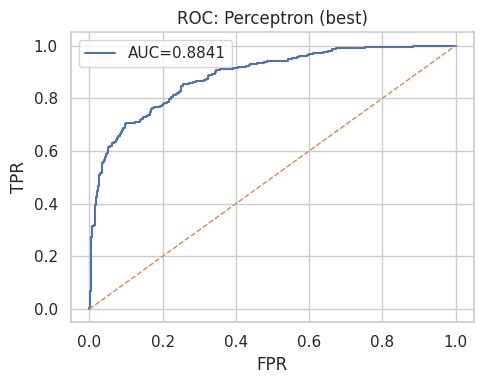

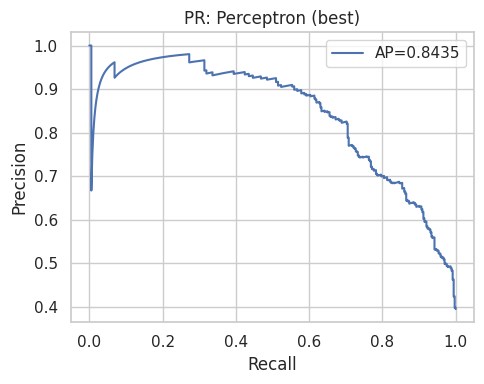

,roc_auc,ap
model,,
LogReg,0.9704,0.9499
Perceptron,0.8841,0.8435


In [13]:

def evaluate_on_test(estimator, X_test, y_test, name="model"):
    y_proba = estimator.predict_proba(X_test)[:,1] if hasattr(estimator, "predict_proba") else None
    y_dec = estimator.decision_function(X_test) if hasattr(estimator, "decision_function") else None
    y_pred = estimator.predict(X_test)

    print(f"=== {name} ===")
    print(classification_report(y_test, y_pred, digits=4))
    cm = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(cm, display_labels=["ham","spam"]).plot(values_format="d")
    plt.title(f"Confusion Matrix: {name}"); plt.show()

    if y_proba is None and y_dec is not None:
        y_proba = (y_dec - y_dec.min()) / (y_dec.max() - y_dec.min() + 1e-12)

    metrics = {}
    if y_proba is not None:
        roc = roc_auc_score(y_test, y_proba)
        fpr,tpr,_ = roc_curve(y_test, y_proba)
        pr, rc, _ = precision_recall_curve(y_test, y_proba)
        ap = average_precision_score(y_test, y_proba)

        plt.figure(figsize=(5,4))
        plt.plot(fpr, tpr, label=f"AUC={auc(fpr,tpr):.4f}")
        plt.plot([0,1],[0,1],"--", lw=1)
        plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title(f"ROC: {name}"); plt.legend(); plt.tight_layout(); plt.show()

        plt.figure(figsize=(5,4))
        plt.plot(rc, pr, label=f"AP={ap:.4f}")
        plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title(f"PR: {name}"); plt.legend(); plt.tight_layout(); plt.show()

        metrics = {"roc_auc": roc, "ap": ap}
    return metrics

best_lr = gs_lr.best_estimator_
best_pc = gs_pc.best_estimator_

metrics_lr = evaluate_on_test(best_lr, X_test, y_test, "LogisticRegression (best)")
metrics_pc = evaluate_on_test(best_pc, X_test, y_test, "Perceptron (best)")

pd.DataFrame([
    {"model":"LogReg","roc_auc":metrics_lr.get("roc_auc"),"ap":metrics_lr.get("ap")},
    {"model":"Perceptron","roc_auc":metrics_pc.get("roc_auc"),"ap":metrics_pc.get("ap")}
]).set_index("model").round(4)



## 8. Валидационные кривые (регуляризация)


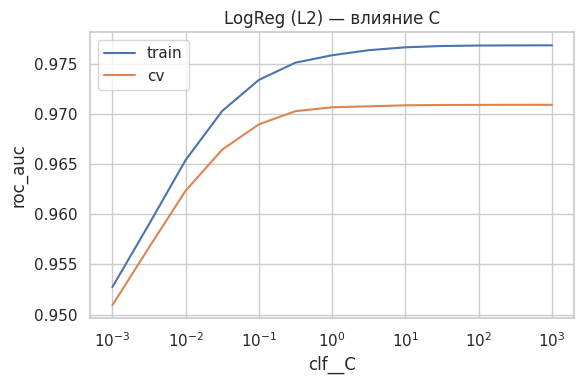

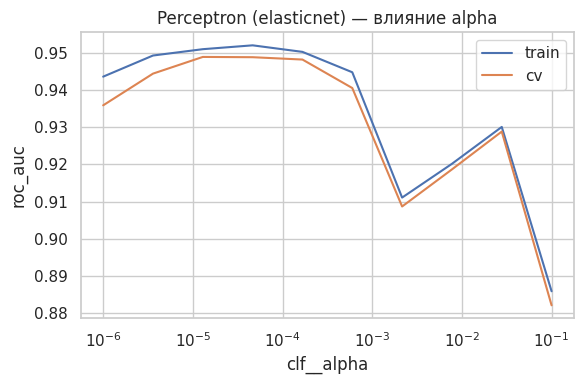

In [14]:

def plot_val_curve(pipe, X, y, param_name, param_range, scoring="roc_auc", logx=True, title=None):
    train_scores, test_scores = validation_curve(
        pipe, X, y, param_name=param_name, param_range=param_range,
        cv=cv, scoring=scoring, n_jobs=-1
    )
    tr_mean, te_mean = train_scores.mean(axis=1), test_scores.mean(axis=1)
    plt.figure(figsize=(6,4))
    if logx:
        plt.semilogx(param_range, tr_mean, label="train"); plt.semilogx(param_range, te_mean, label="cv")
    else:
        plt.plot(param_range, tr_mean, label="train"); plt.plot(param_range, te_mean, label="cv")
    plt.xlabel(param_name); plt.ylabel(scoring); plt.title(title or f"Validation: {param_name}")
    plt.legend(); plt.tight_layout(); plt.show()

pipe_lr_l2 = Pipeline([("prep", preprocess),
                       ("clf", LogisticRegression(penalty="l2", solver="saga", max_iter=5000, random_state=RANDOM_STATE))])
plot_val_curve(pipe_lr_l2, X, y, "clf__C", np.logspace(-3, 3, 13), "roc_auc", True, "LogReg (L2) — влияние C")


pipe_pc_el = Pipeline([("prep", preprocess),
                       ("clf", Perceptron(penalty="elasticnet", random_state=RANDOM_STATE, early_stopping=True))])
plot_val_curve(pipe_pc_el, X, y, "clf__alpha", np.logspace(-6, -1, 10), "roc_auc", True, "Perceptron (elasticnet) — влияние alpha")



## 9. Кривые обучения


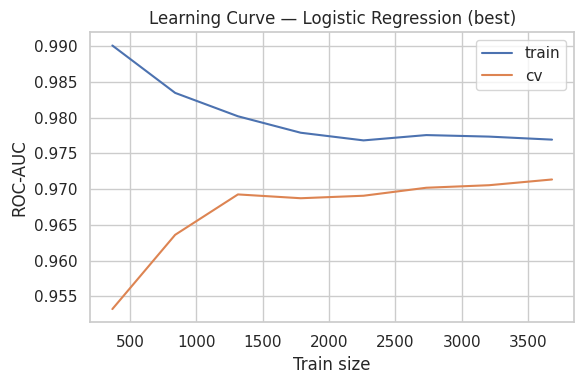

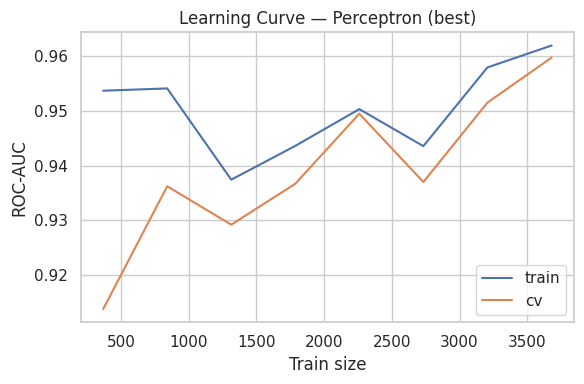

In [15]:

def plot_learning_curve(pipe, X, y, title):
    sizes, train_scores, test_scores = learning_curve(
        pipe, X, y, cv=cv, n_jobs=-1, scoring="roc_auc",
        train_sizes=np.linspace(0.1, 1.0, 8), shuffle=True, random_state=RANDOM_STATE
    )
    plt.figure(figsize=(6,4))
    plt.plot(sizes, train_scores.mean(axis=1), label="train")
    plt.plot(sizes, test_scores.mean(axis=1), label="cv")
    plt.xlabel("Train size"); plt.ylabel("ROC-AUC"); plt.title(title)
    plt.legend(); plt.tight_layout(); plt.show()

plot_learning_curve(best_lr, X, y, "Learning Curve — Logistic Regression (best)")
plot_learning_curve(best_pc, X, y, "Learning Curve — Perceptron (best)")



## 10. Интерпретация для Logistic Regression (важность признаков)


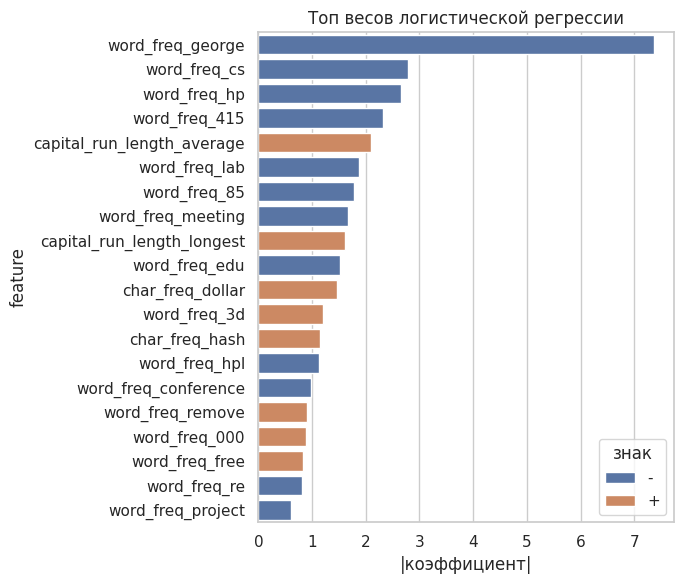

,feature,coef
26,word_freq_george,-7.3706
40,word_freq_cs,-2.7812
24,word_freq_hp,-2.6649
33,word_freq_415,-2.3248
54,capital_run_length_average,2.1033
28,word_freq_lab,-1.8823
34,word_freq_85,-1.7850
41,word_freq_meeting,-1.6685
55,capital_run_length_longest,1.6086
45,word_freq_edu,-1.5244


In [16]:

prep = best_lr.named_steps["prep"]
feat_names = prep.get_feature_names_out() if hasattr(prep, "get_feature_names_out") else np.array([c for c in df.columns if c!="spam"])
clf_lr = best_lr.named_steps["clf"]
coefs = clf_lr.coef_.ravel()
coef_df = pd.DataFrame({"feature": feat_names, "coef": coefs, "abs": np.abs(coefs)}).sort_values("abs", ascending=False)

top_k = 20
plt.figure(figsize=(7,6))
sns.barplot(data=coef_df.head(top_k), x="abs", y="feature", hue=(coef_df.head(top_k)["coef"]>0).map({True:"+",False:"-"}), dodge=False)
plt.title("Топ весов логистической регрессии"); plt.xlabel("|коэффициент|"); plt.ylabel("feature"); plt.legend(title="знак"); plt.tight_layout(); plt.show()

coef_df.head(30).drop(columns="abs").round(4)



## 11. Сводка и вывод


In [17]:

def holdout_metrics(est, X_test, y_test, name):
    y_proba = est.predict_proba(X_test)[:,1] if hasattr(est, "predict_proba") else None
    if y_proba is None and hasattr(est, "decision_function"):
        s = est.decision_function(X_test)
        y_proba = (s - s.min())/(s.max()-s.min()+1e-12)
    y_pred = est.predict(X_test)
    bal_acc = (confusion_matrix(y_test, y_pred, normalize="true").diagonal().mean())
    return dict(model=name, roc_auc=roc_auc_score(y_test, y_proba), ap=average_precision_score(y_test, y_proba), bal_acc=bal_acc)

summary = pd.DataFrame([
    holdout_metrics(best_lr, X_test, y_test, "LogReg (best)"),
    holdout_metrics(best_pc, X_test, y_test, "Perceptron (best)")
]).set_index("model").round(4)
summary


,roc_auc,ap,bal_acc
model,,,
LogReg (best),0.9704,0.9499,0.9219
Perceptron (best),0.8841,0.8435,0.7902



**Комментарий.**  
В задачах линейной классификации с шумом и разреженными индикаторными признаками логистическая регрессия с регуляризацией обычно превосходит перцептрон: она оптимизирует логистическую потерю, устойчивее к выбросам, выдает вероятности и позволяет тонко настраивать регуляризаторы (L1/L2/ElasticNet). Перцептрон чувствителен к масштабу и шуму; грамотное скалирование и регуляризация улучшают результат, но обычно он уступает по ROC/PR.



## 12. Доп. эксперименты: регуляризаторы для LogReg


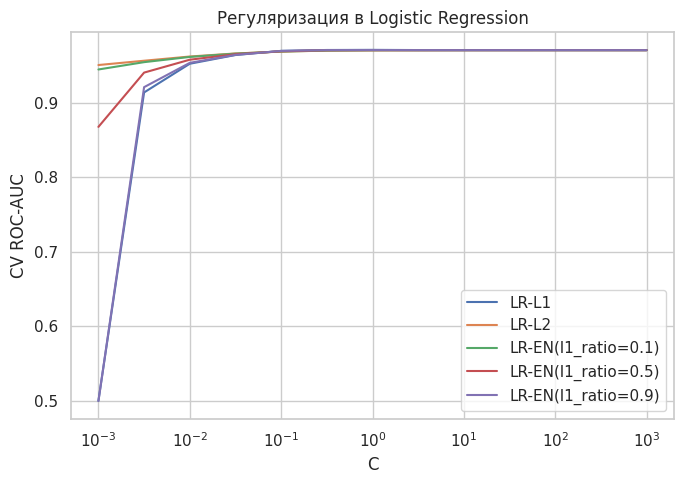

In [18]:

def trace_lr_cv(penalty, l1_ratio=None, C_grid=np.logspace(-3,3,13)):
    scores = []
    for C in C_grid:
        lr = Pipeline([("prep", preprocess),
                       ("clf", LogisticRegression(solver="saga", penalty=penalty, l1_ratio=l1_ratio,
                                                   C=C, max_iter=5000, random_state=RANDOM_STATE))])
        cv_res = cross_validate(lr, X, y, cv=cv, scoring="roc_auc", n_jobs=-1)
        scores.append(cv_res["test_score"].mean())
    return C_grid, np.array(scores)

C_grid = np.logspace(-3,3,13)
curves = []
for pen in ["l1","l2"]:
    c, s = trace_lr_cv(penalty=pen, C_grid=C_grid)
    curves.append((f"LR-{pen.upper()}", c, s))
for l1r in [0.1,0.5,0.9]:
    c, s = trace_lr_cv(penalty="elasticnet", l1_ratio=l1r, C_grid=C_grid)
    curves.append((f"LR-EN(l1_ratio={l1r})", c, s))

plt.figure(figsize=(7,5))
for name, c, s in curves: plt.semilogx(c, s, label=name)
plt.xlabel("C"); plt.ylabel("CV ROC-AUC"); plt.title("Регуляризация в Logistic Regression")
plt.legend(); plt.tight_layout(); plt.show()



## 13. Сохранение лучших моделей


In [19]:

outdir = pathlib.Path("models"); outdir.mkdir(exist_ok=True)
joblib.dump(best_lr, outdir / "logreg_best.pkl")
joblib.dump(best_pc, outdir / "perceptron_best.pkl")
print("Сохранено в:", outdir.resolve())


Сохранено в: /home/elisey/python_proj/ml_7sem/models
